# Users Overview Analysis

For the actual telecom dataset, you‘re expected to conduct a full User Overview analysis & the following sub-tasks are your guidance: 
Start by 
- identifying the top 10 handsets used by the customers.
- Then, identify the top 3 handset manufacturers
- Next, identify the top 5 handsets per top 3 handset manufacturer
- Make a short interpretation and recommendation to marketing teams


# imports

In [1]:
# general
import os
import gc
import sys

# wranglers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# custom modules
cwd = os.getcwd()
parent = cwd.replace('/notebooks', '')
sys.path.insert(0, parent) 

from scripts.utils import DataLoader, Plotters, CleanDataFrame

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option("expand_frame_repr", False)
# pd.set_option('display.float_format', '{:.2f}'.format)

# load data

In [3]:
df = DataLoader("../data", "Week1_challenge_data_source.csv").read_csv()
plotter = Plotters(w=9, h=6)
cleaner = CleanDataFrame()
df = cleaner.rename_columns(df)


# Top 10 handsets used by customers

Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: Handset Type, dtype: int64

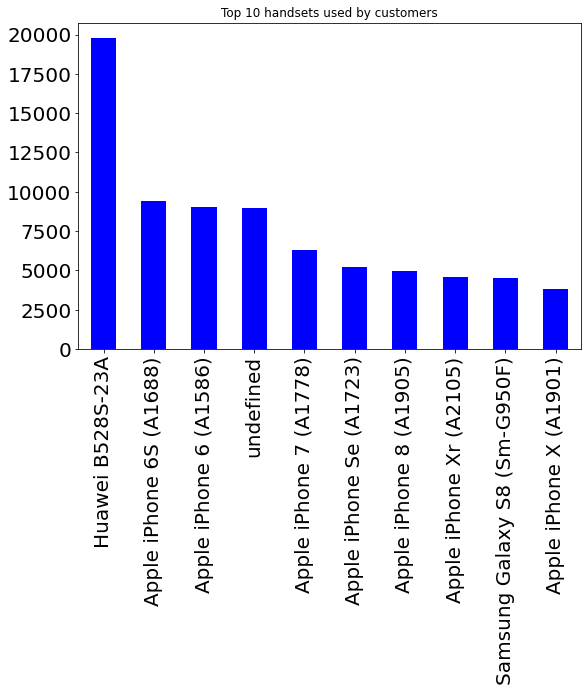

In [4]:
top_10_handsets = plotter.plot_top_n_counts(
    df, 'Handset Type', 10, title="Top 10 handsets used by customers", color="blue")
top_10_handsets


# Top 3 handset manufacturers

Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64

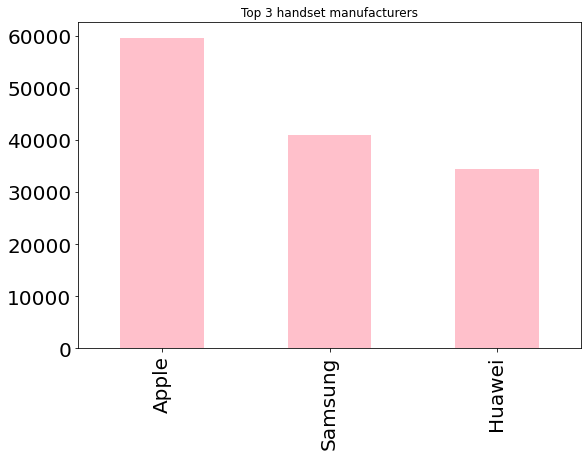

In [5]:
top_3_handset_manu = plotter.plot_top_n_counts(
    df, 'Handset Manufacturer', 3, color='pink', title='Top 3 handset manufacturers')
top_3_handset_manu


# Top 5 handsets per top 3 handset manufacturer

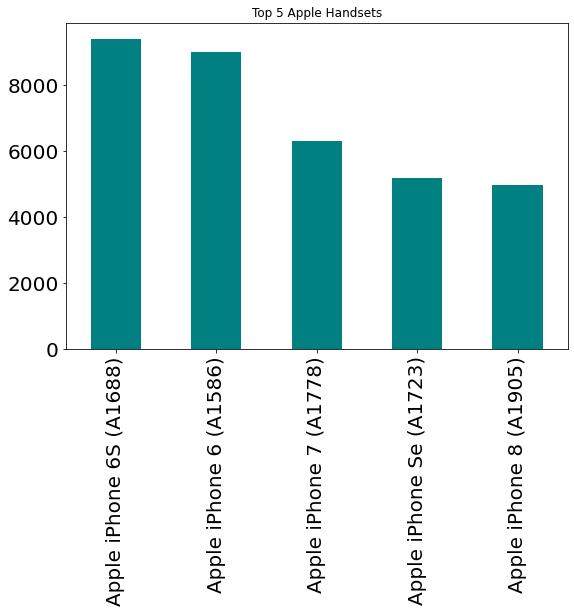

In [6]:
apple = df[df['Handset Manufacturer'] == 'Apple']
top_5_apple = plotter.plot_top_n_counts(
    apple, 'Handset Type', 5, "Top 5 Apple Handsets", color="teal")


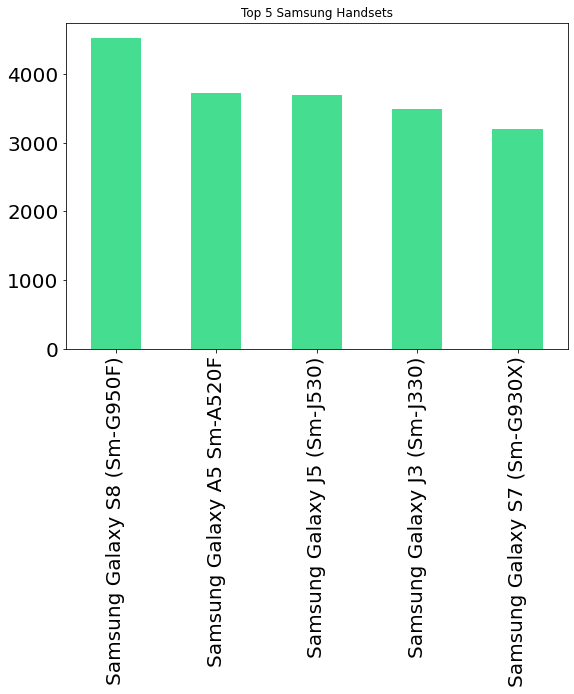

In [7]:
samsung = df[df['Handset Manufacturer'] == 'Samsung']
top_5_samsung = plotter.plot_top_n_counts(
    samsung, 'Handset Type', 5, "Top 5 Samsung Handsets", color="#45De90")


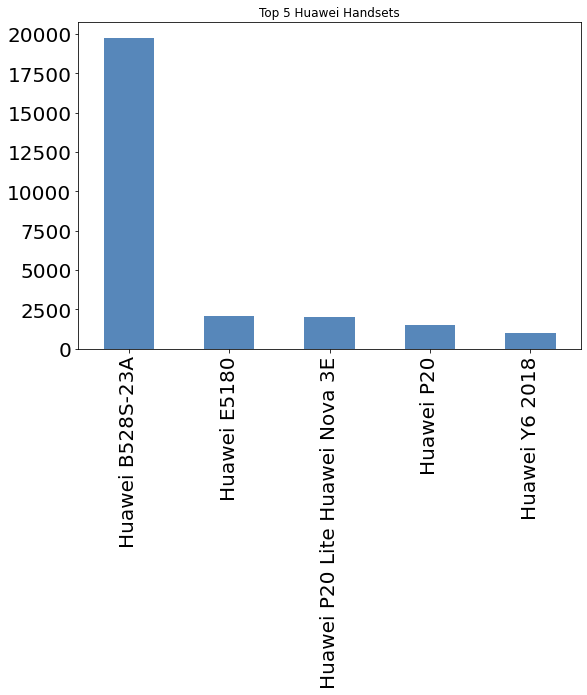

In [8]:
huawei = df[df['Handset Manufacturer'] == 'Huawei']
top_5_huawei = plotter.plot_top_n_counts(
    huawei, 'Handset Type', 5, "Top 5 Huawei Handsets", color="#5787BA")


# Users’ behavior on applications
**(Social Media, Google, Email, Youtube, Netflix, Gaming, Other)**

Aggregate per user the following information in the column  

    - number of xDR sessions
    - Session duration
    - the total download (DL) and upload (UL) data
    - the total data volume (in Bytes) during this session for each application



## Note on a couple of columns (**IMSI** and **MSISDN**)

Since this tasks involved I needed to see if I had columns that would help me identify specifc users. 
And a quick scan of the `Field Descriptions.xlsx` file gave me the idea that the **IMSI** (***International Mobile Subscriber Identity***) and **MSISDN** (***Mobile Station Integrated Services Digital Network***) might be good candidates.
I also considered using the **IMEI** (***International Mobile Equipment Identity***) but then there might be cases where the same person uses multiple handsets.

The **IMSI** is an identifier that is stored on the **SIM** (***subscriber identity module***) card of a subscriber. It is a static 15 digit number used by Network operators to identify subsribers on a network. 
The **MSISDN** is the phone number assigned to a subscriber inorder for it to communicate with other subscribers. They are also not bound to a single device or SIM. 
A subscriber could even have multiple **MSISDN** associated with a single **IMSI**

Both identifiers might work for the task with a few twists, but I will stick to the **MSISDN** since the client specifically asks to group cutomers using it.

[**Reference**](https://www.wirelesslogic.com/what-is-msisdn/)

In [9]:
unique_MSISDN = df['MSISDN/Number'].unique()
print(f"We have {unique_MSISDN.shape[0]} unique MSISDN identifiers in our dataset")


We have 106857 unique MSISDN identifiers in our dataset


## Task 1.1 - Aggrigations per user

### Number of xDR sessions

Let's look at our per user xDR counts


MSISDN/Number
3.360100e+10    1
3.360100e+10    1
3.360100e+10    1
3.360101e+10    1
3.360101e+10    2
Name: Bearer Id, dtype: int64

The unique counts are the following


array([ 1,  2,  3,  5,  0,  4, 12,  6,  9,  7, 17,  8, 18, 10, 11, 16, 13,
       15])

And the Mean is as follows


1.389776896009583

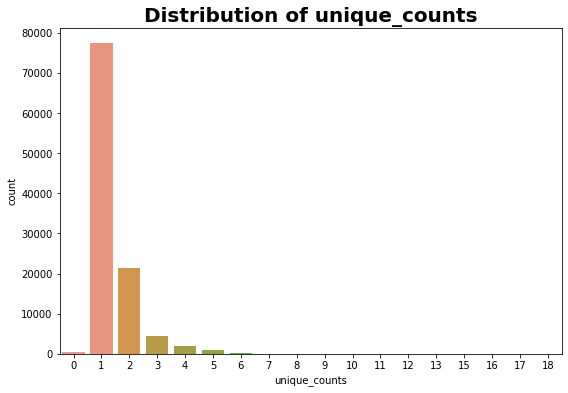

In [10]:
user_xdr_count = df.groupby(by='MSISDN/Number')['Bearer Id'].count()
print("Let's look at our per user xDR counts")
display(user_xdr_count.head())
print("The unique counts are the following")
display(user_xdr_count.unique())

print("And the Mean is as follows")
display(user_xdr_count.mean())
plotter.plot_count(pd.DataFrame(data=user_xdr_count.values,
                   columns=['unique_counts']), 'unique_counts')


This shows us that most users have a single xdr session in our data.

### Session Duration

In [11]:
user_session_durations = df.groupby(by='MSISDN/Number')['Dur. ms'].sum()
assert user_session_durations.shape[0], unique_MSISDN.shape[0]
print("Let's look at our per user session durations in (ms)")
display(user_session_durations.head())


Let's look at our per user session durations in (ms)


MSISDN/Number
3.360100e+10    116720140.0
3.360100e+10    181230963.0
3.360100e+10    134969374.0
3.360101e+10     49878024.0
3.360101e+10     37104453.0
Name: Dur. ms, dtype: float64

### The total download (DL) and upload (UL) data

In [12]:
user_total_DLUL = df.groupby(
    by='MSISDN/Number')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum()
print("This will be the sum of each users UL and DL usages in (Bytes)")
display(user_total_DLUL.head())
print("But we need the total as a single number for each user, so we sum it across the columns")
user_total_DLUL = user_total_DLUL.sum(axis=1)
display(user_total_DLUL.head())


This will be the sum of each users UL and DL usages in (Bytes)


,Total UL (Bytes),Total DL (Bytes)
MSISDN/Number,,
3.360100e+10,36053108.0,8.426375e+08
3.360100e+10,36104459.0,1.207552e+08
3.360100e+10,39306820.0,5.566597e+08
3.360101e+10,20327526.0,4.019932e+08
3.360101e+10,94280527.0,1.363130e+09


But we need the total as a single number for each user, so we sum it across the columns


MSISDN/Number
3.360100e+10    8.786906e+08
3.360100e+10    1.568596e+08
3.360100e+10    5.959665e+08
3.360101e+10    4.223207e+08
3.360101e+10    1.457411e+09
dtype: float64

### The total data volume (in Bytes) during these session for each application

In [13]:
app_columns = [col for col in df.columns if col.endswith('L (Bytes)')][2:-2]
app_columns.append('Dur. ms')
display(app_columns)
user_app_ULDL_data_vol = df.groupby(by=['MSISDN/Number'])[app_columns].sum()
user_app_ULDL_data_vol.head()


['Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Email DL (Bytes)',
 'Email UL (Bytes)',
 'Youtube DL (Bytes)',
 'Youtube UL (Bytes)',
 'Netflix DL (Bytes)',
 'Netflix UL (Bytes)',
 'Gaming DL (Bytes)',
 'Gaming UL (Bytes)',
 'Other DL (Bytes)',
 'Other UL (Bytes)',
 'Dur. ms']

,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Dur. ms
MSISDN/Number,,,,,,,,,,,,,,,
3.360100e+10,2206504.0,25631.0,3337123.0,1051882.0,837400.0,493962.0,14900201.0,6724347.0,10265105.0,16915876.0,8.110911e+08,1367528.0,377096990.0,9473882.0,116720140.0
3.360100e+10,2598548.0,62017.0,4197697.0,1137166.0,2828821.0,478960.0,5324251.0,7107972.0,770569.0,10451194.0,1.050353e+08,14714780.0,279557701.0,2152370.0,181230963.0
3.360100e+10,3148004.0,47619.0,3343483.0,99643.0,2436500.0,768880.0,2137272.0,19196298.0,16525919.0,2827981.0,5.290685e+08,9759228.0,495086501.0,6607171.0,134969374.0
3.360101e+10,251469.0,28825.0,5937765.0,3740728.0,2178618.0,106052.0,4393123.0,2584198.0,1157362.0,784730.0,3.880748e+08,3051292.0,25248001.0,10031701.0,49878024.0
3.360101e+10,2861230.0,51312.0,13728668.0,4770948.0,2247808.0,1057661.0,10339971.0,31193031.0,24971647.0,24230077.0,1.308981e+09,5816727.0,777643713.0,27160771.0,37104453.0


Now, I will create a new dataframe to combine the UL and DL volume for each app and assign back to the respective users

In [14]:
user_app_total_data_vol = user_app_ULDL_data_vol.copy()
app_ULDL_columns = user_app_total_data_vol.columns.tolist()

app_columns = [[app_ULDL_columns[i], app_ULDL_columns[i+1]]
               for i in range(0, len(app_ULDL_columns)-1, 2)]


In [15]:
for app in app_columns[:-1]:
    app_name = " ".join(app[0].split()[:-2]).strip()
    user_app_total_data_vol[app_name] = user_app_total_data_vol[app].sum(
        axis=1)
    user_app_total_data_vol.drop(columns=app, inplace=True)
user_app_total_data_vol.head()


,Other DL (Bytes),Other UL (Bytes),Dur. ms,Social Media,Google,Email,Youtube,Netflix,Gaming
MSISDN/Number,,,,,,,,,
3.360100e+10,377096990.0,9473882.0,116720140.0,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08
3.360100e+10,279557701.0,2152370.0,181230963.0,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08
3.360100e+10,495086501.0,6607171.0,134969374.0,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08
3.360101e+10,25248001.0,10031701.0,49878024.0,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08
3.360101e+10,777643713.0,27160771.0,37104453.0,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09


## Univariate, Bivariate and Multivariate analysis
Conduct an exploratory data analysis on those data & communicate useful insights. 
Ensure that you identify and treat all missing values and outliers in the dataset by replacing by the mean of the corresponding column.

In [29]:
dur = df[['Dur. (ms).1', 'Dur. (ms)']]

In [30]:
dur[['Dur. (ms).1']] = dur[['Dur. (ms).1']].apply(lambda x: round(x/1000, 0))
# (dur[['Dur. (ms).1']] == dur[['Dur. (ms)']]).sum() == dur.shape[0]
dur.head()

/tmp/ipykernel_38089/4279491657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dur[['Dur. (ms).1']] = dur[['Dur. (ms).1']].apply(lambda x: round(x/1000, 0))


,Dur. (ms).1,Dur. (ms)
0,1823653.0,1823652.0
1,1365104.0,1365104.0
2,1361763.0,1361762.0
3,1321510.0,1321509.0
4,1089009.0,1089009.0


In [16]:
cleaner = CleanDataFrame()

In [17]:
clean_df = cleaner.fix_datatypes(df)
clean_df = cleaner.handle_missing_value(clean_df, verbose=False)

### Non-Graphical Univariate Analysis

Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable and provide useful interpretation. 


In [18]:
# for col in clean_df.columns:
    # print(f"{col} Mean: {round(clean_df[col].describe())} KBs")

In [19]:
clean_df.describe()

,Start ms,End ms,Dur. (ms),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,150001.000000,150001.000000,1.500010e+05,150001.000000,150001.000000,150001.00000,150001.000000,1.500010e+05,1.500010e+05,150001.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,499.188199,498.800888,1.046084e+05,97.774455,15.315031,13299.95768,1770.417264,8.915464e+06,2.836918e+05,92.880721,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,288.610872,288.096693,8.103736e+04,559.909444,76.687998,23971.82300,4625.342183,1.176582e+08,1.578013e+07,13.015062,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127635e+07,2.441421e+08
min,0.000000,0.000000,7.142000e+03,0.000000,0.000000,0.00000,0.000000,2.000000e+00,1.000000e+00,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,250.000000,251.000000,5.744200e+04,35.000000,3.000000,43.00000,47.000000,5.687300e+05,2.094950e+04,91.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322203e+07,2.431072e+08
50%,499.000000,500.000000,8.639900e+04,45.000000,5.000000,63.00000,63.000000,5.687300e+05,2.094950e+04,100.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,749.000000,750.000000,1.324300e+05,62.000000,11.000000,19710.00000,1120.000000,5.687300e+05,2.094950e+04,100.000000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657051e+08
max,999.000000,999.000000,1.859336e+06,96923.000000,7120.000000,378160.00000,58613.000000,4.294426e+09,2.908226e+09,100.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


### Graphical Univariate Analysis
Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options for each variable and interpret your findings.

#### Visualize outliers with box plots

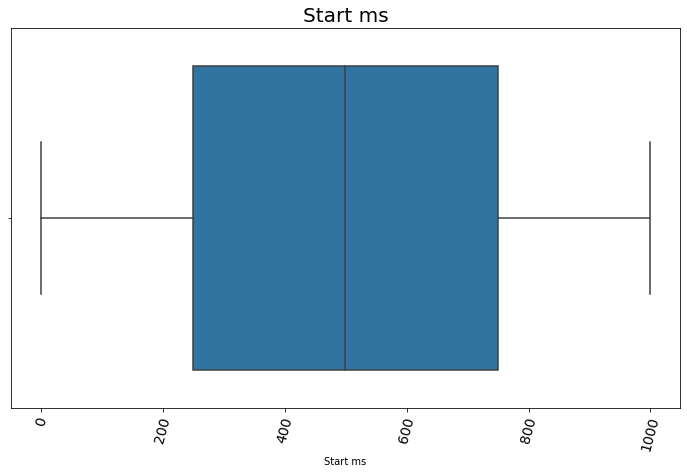

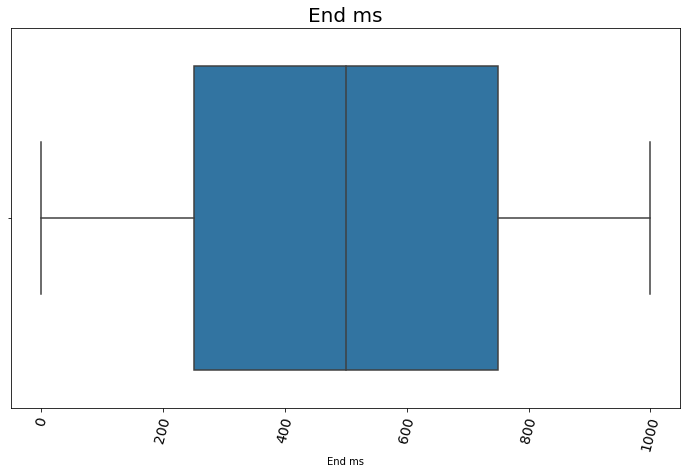

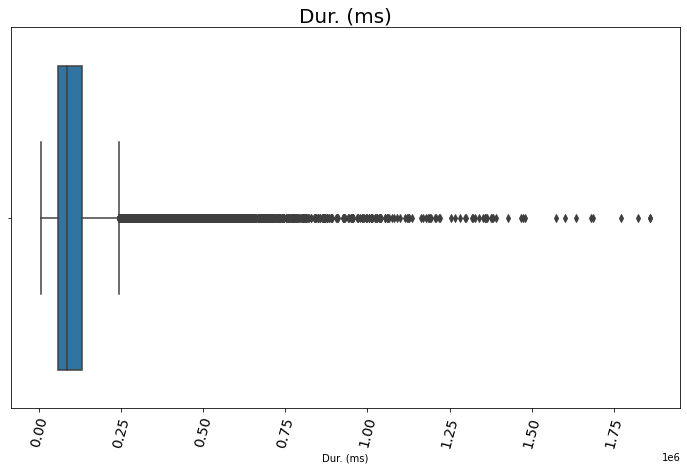

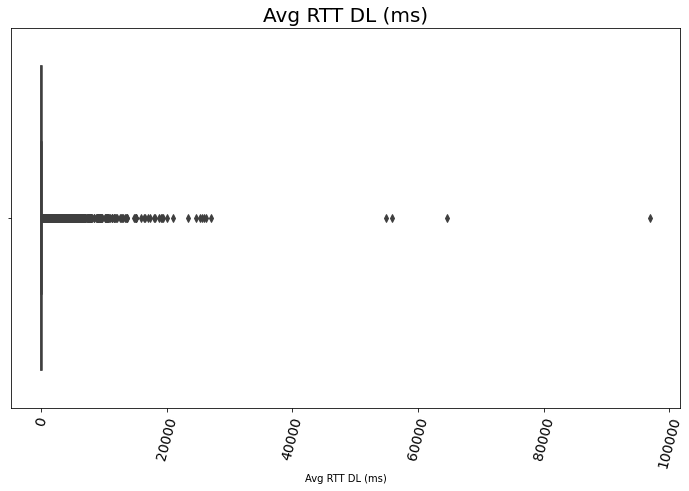

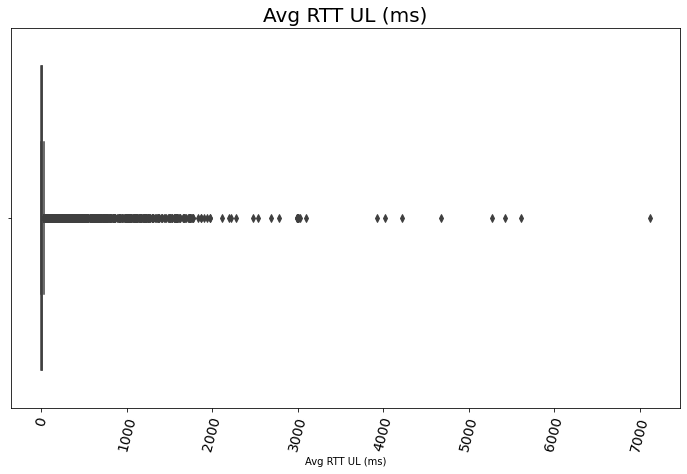

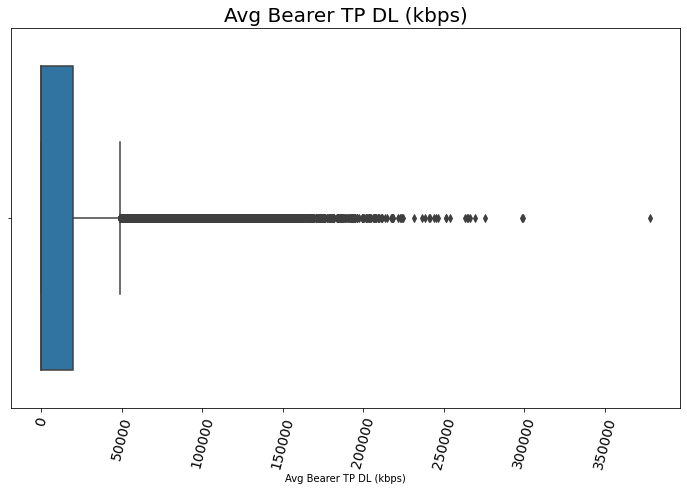

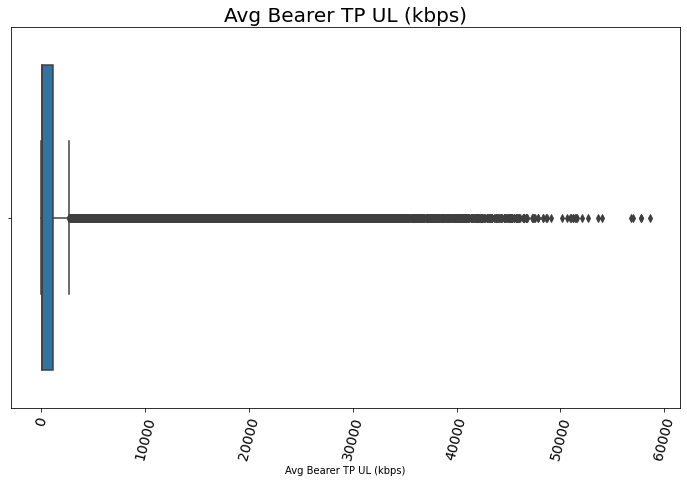

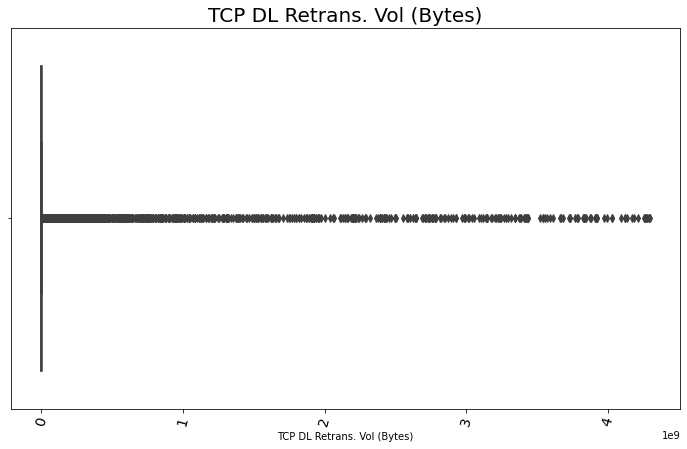

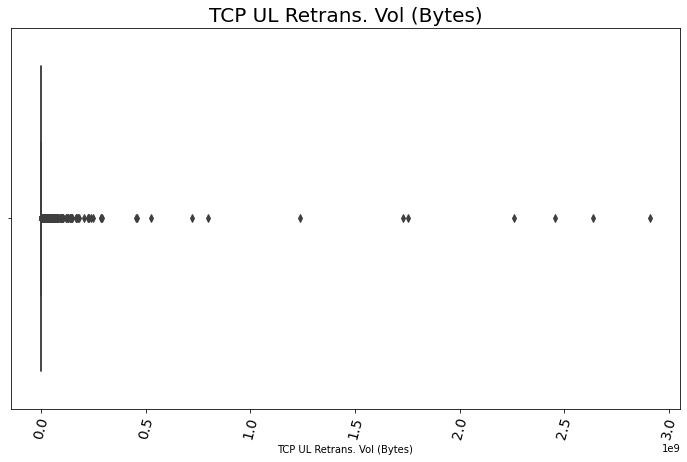

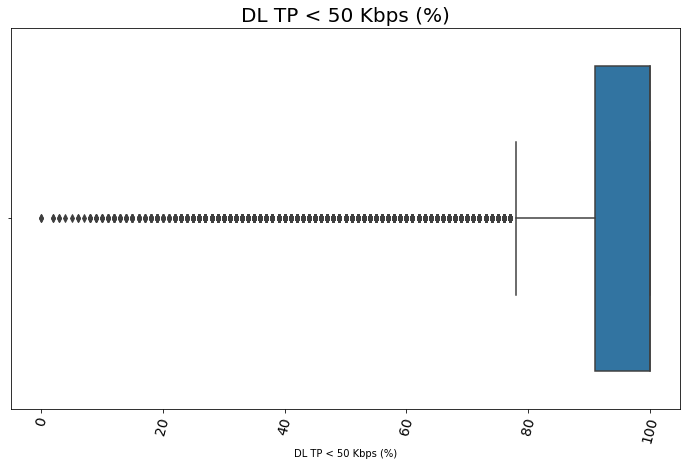

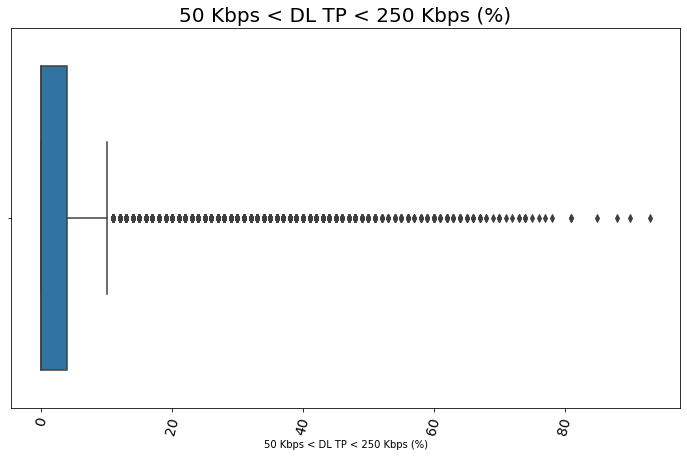

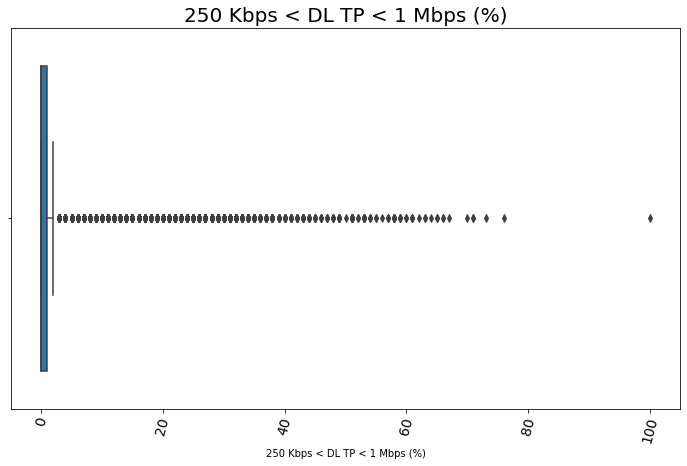

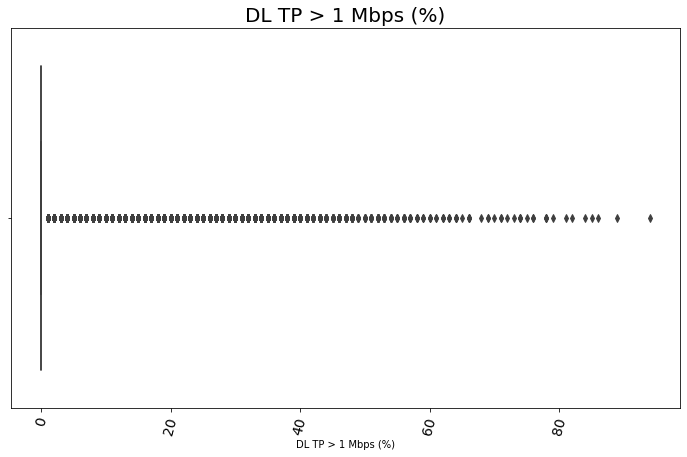

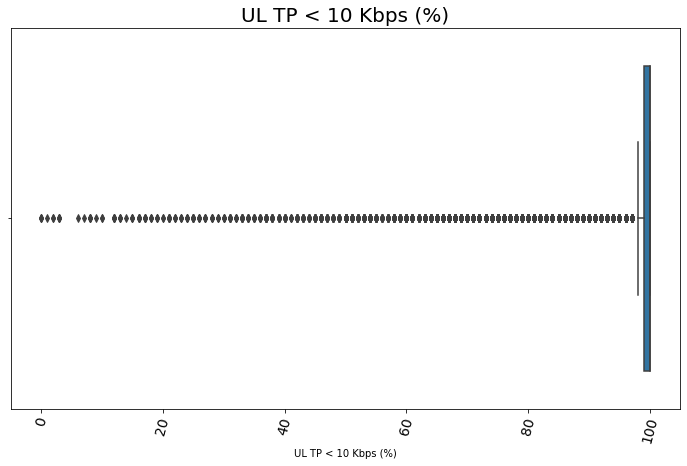

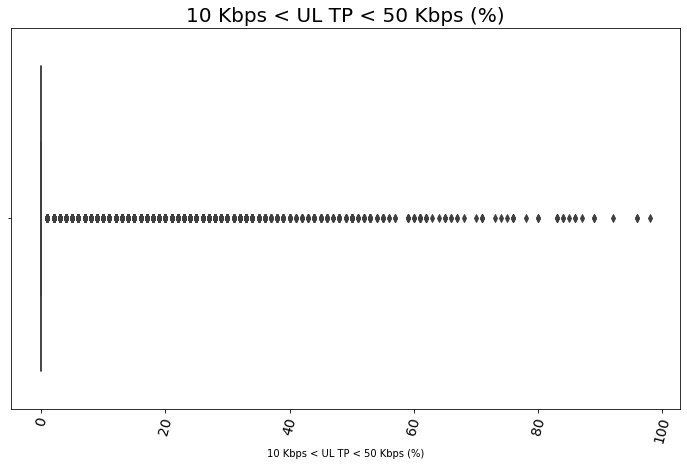

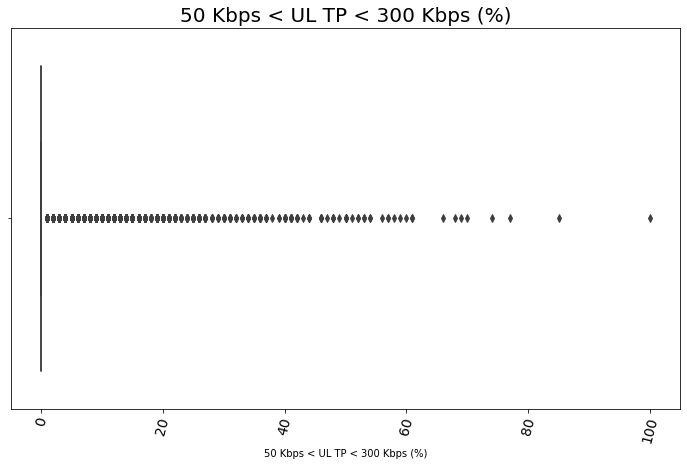

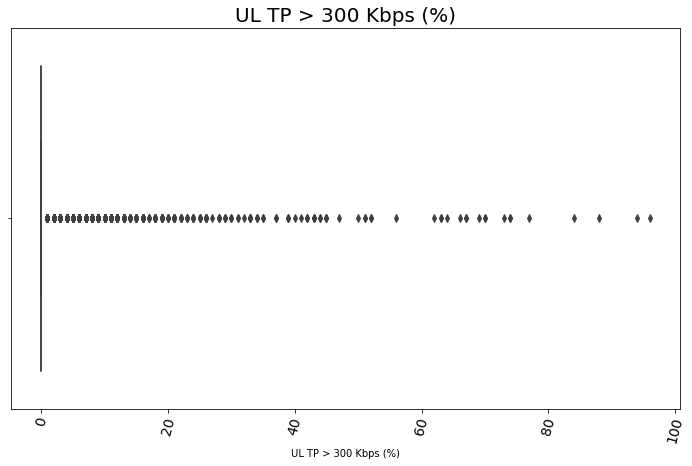

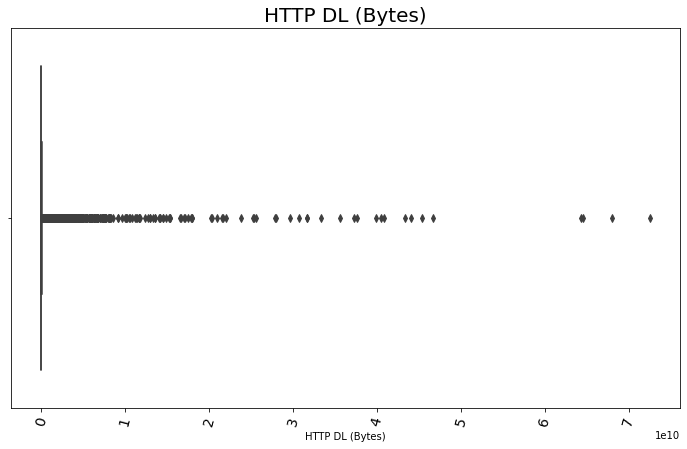

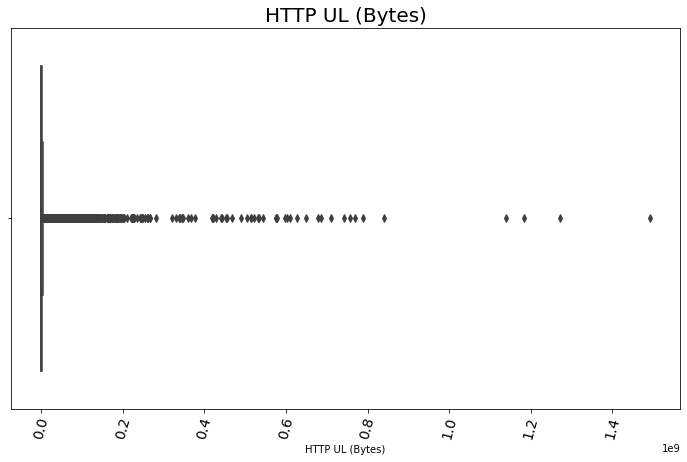

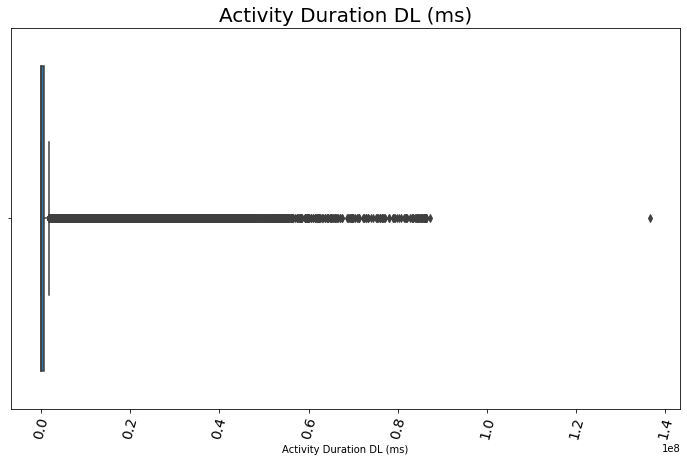

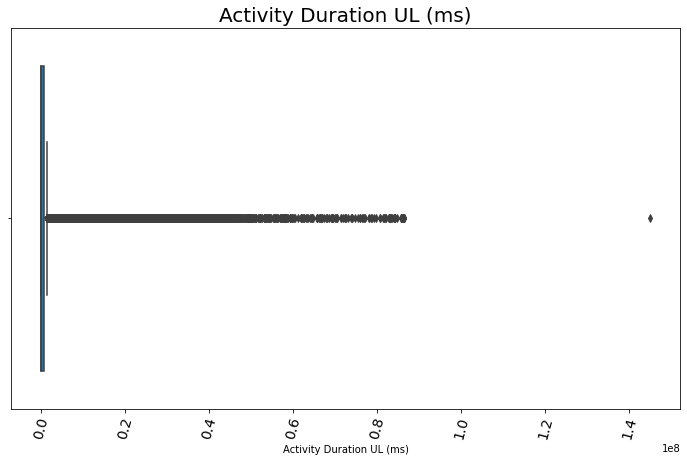

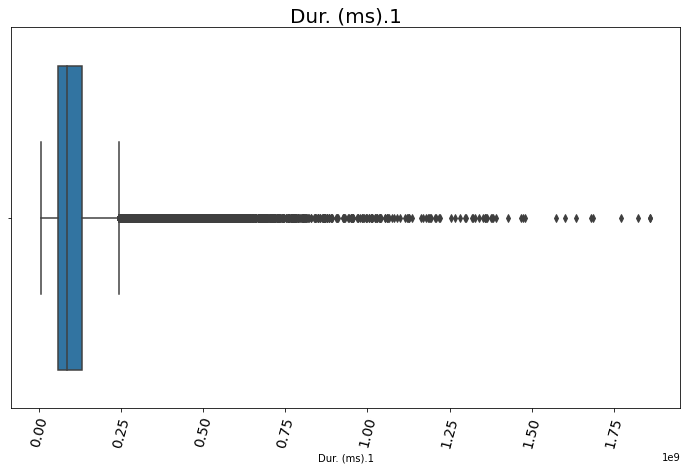

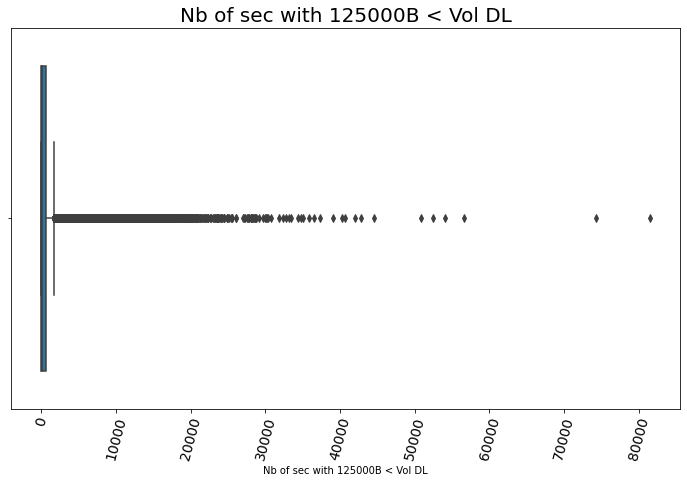

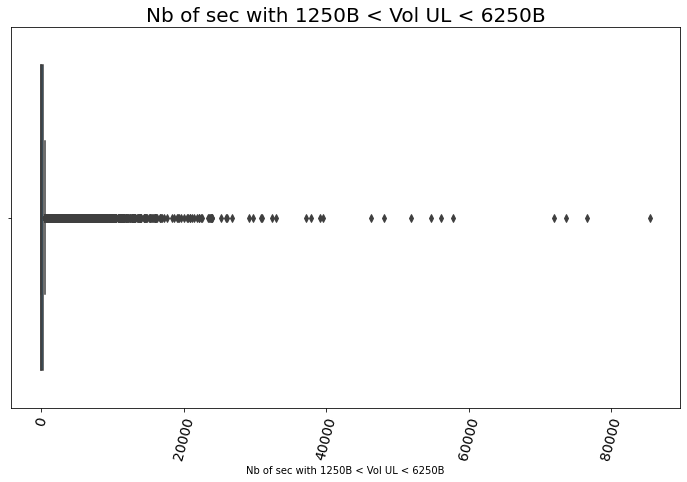

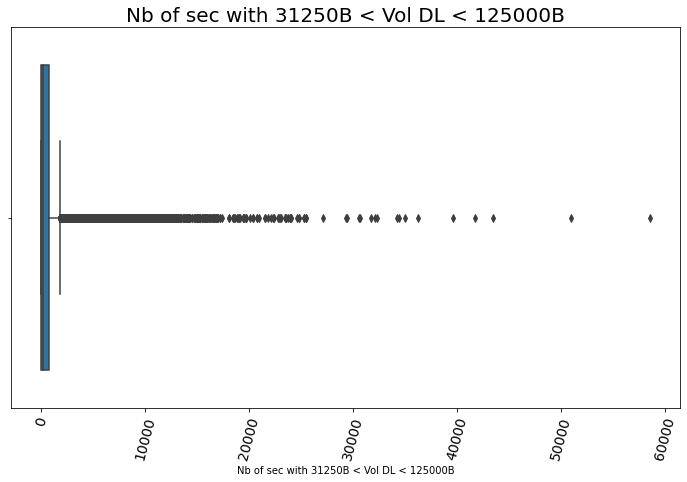

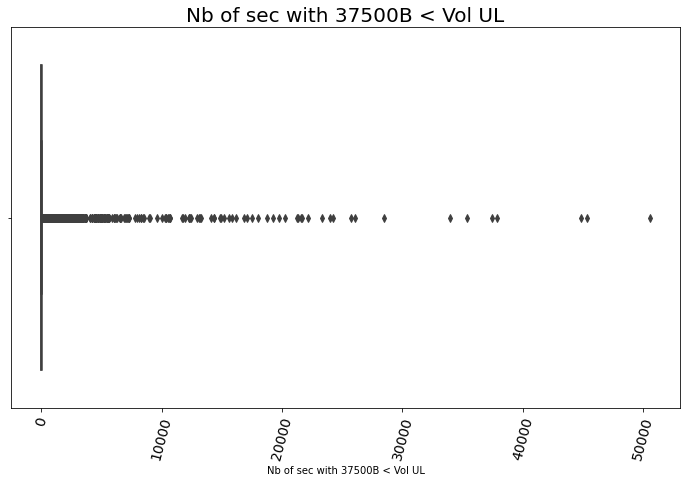

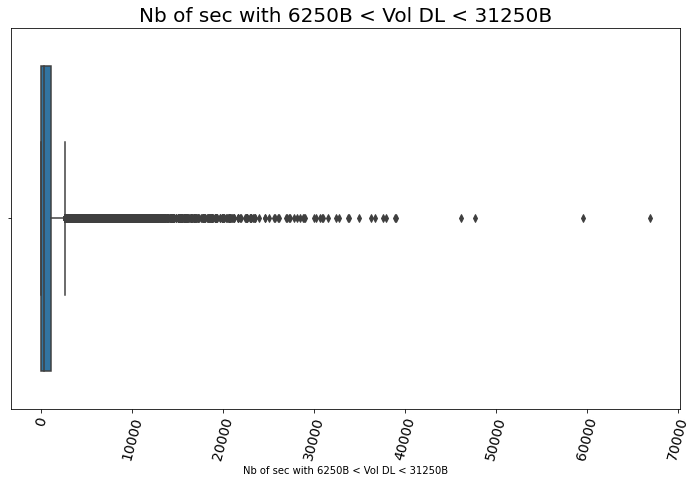

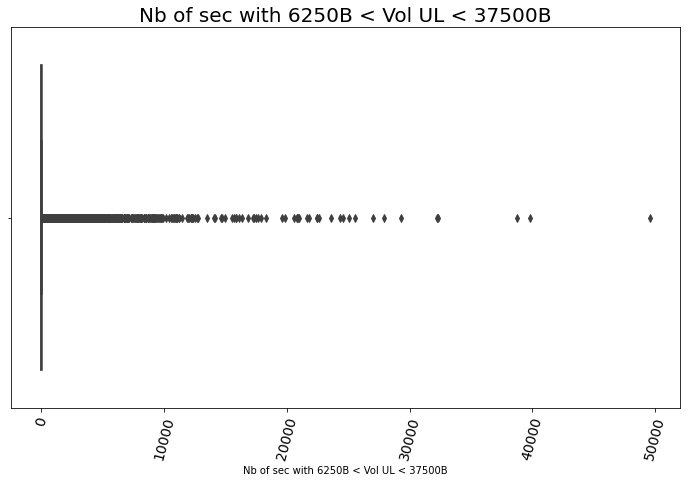

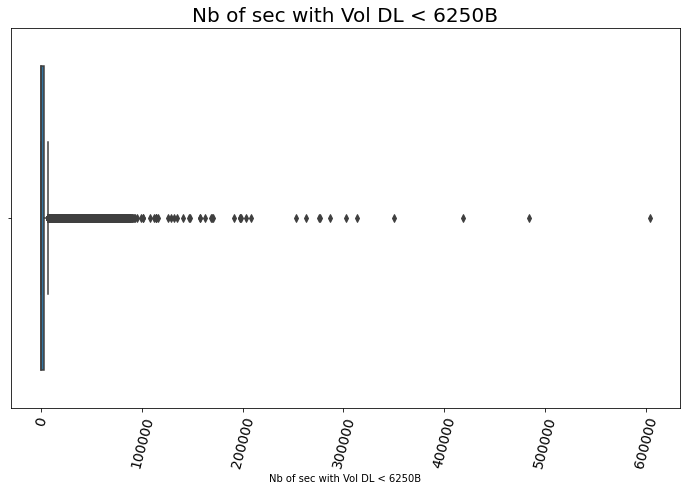

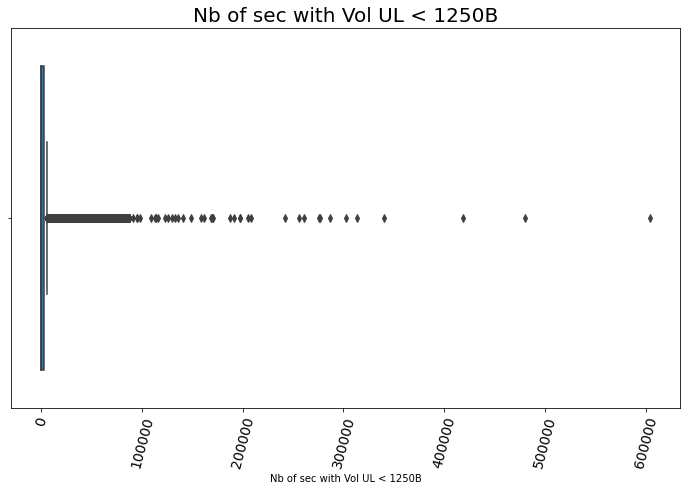

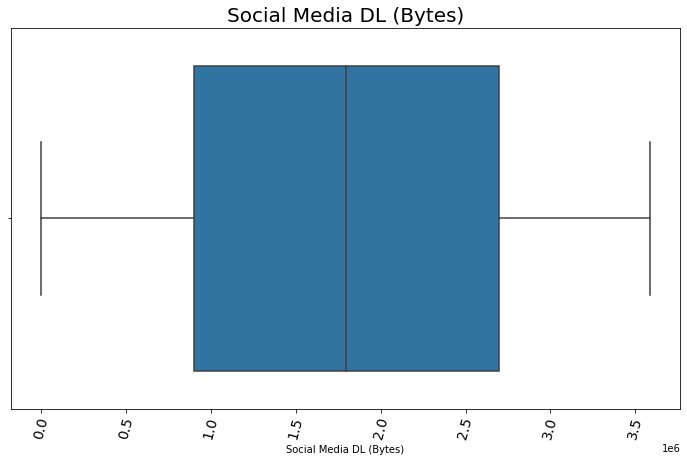

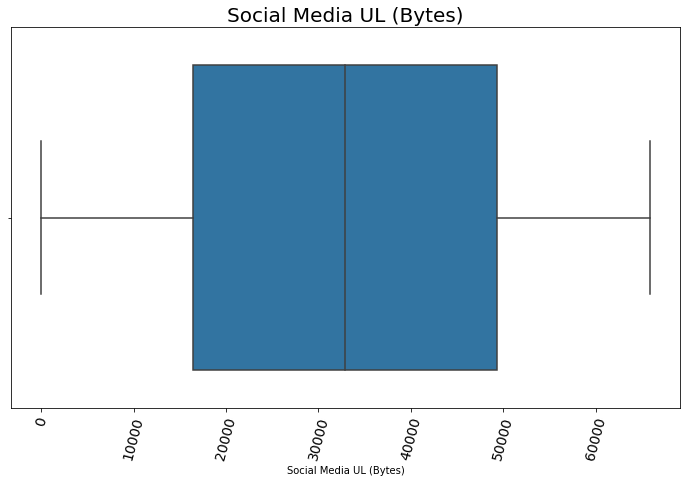

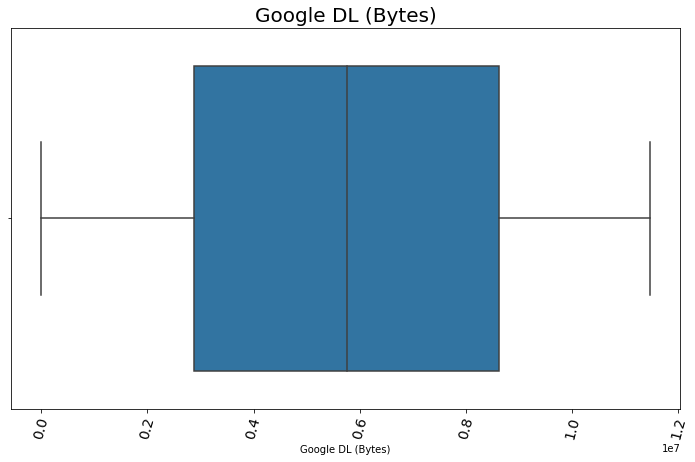

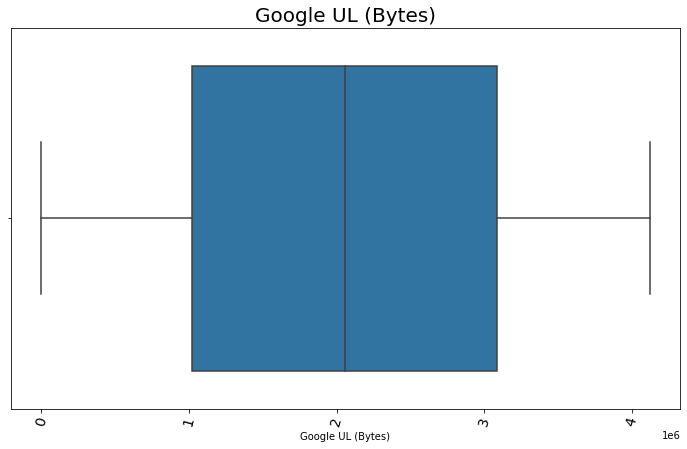

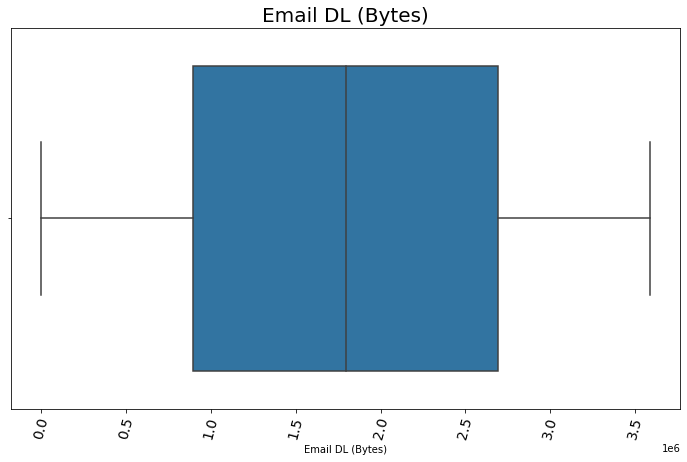

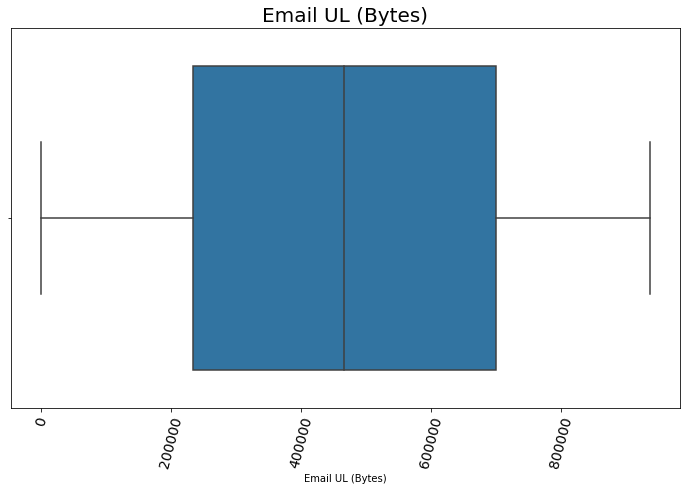

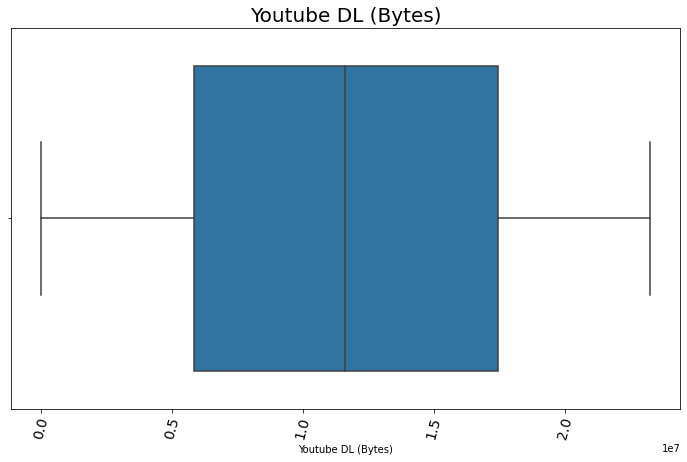

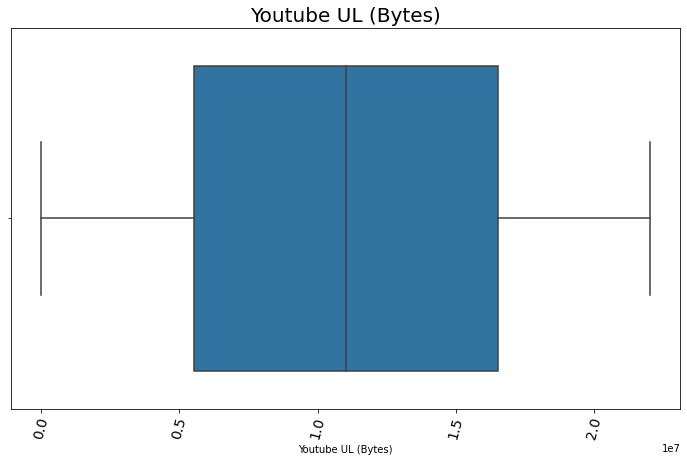

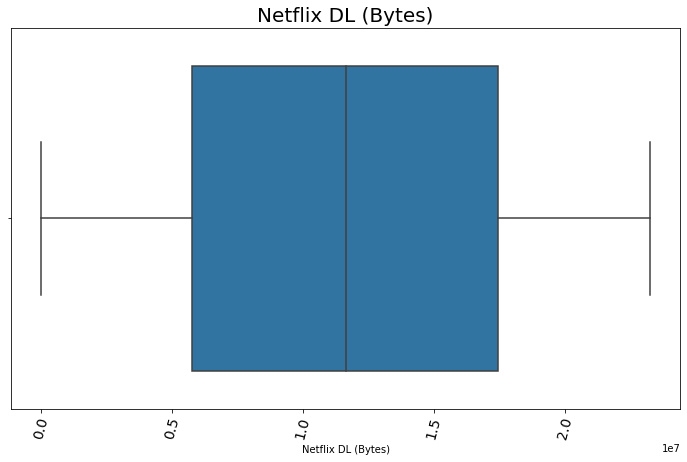

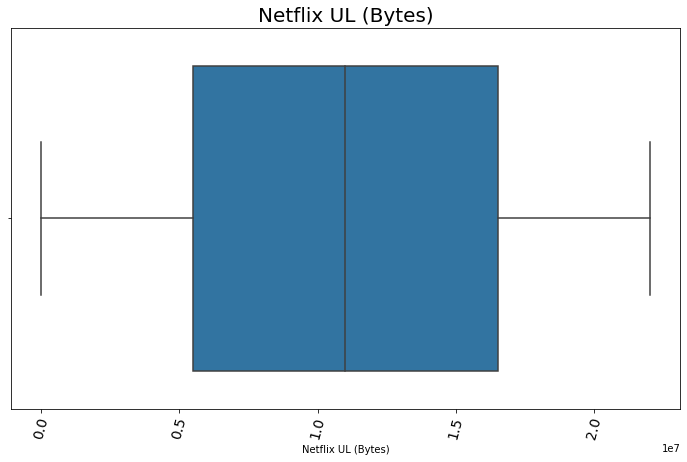

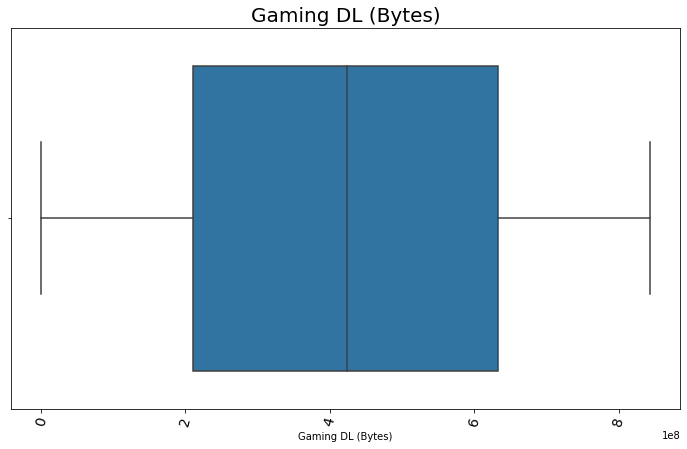

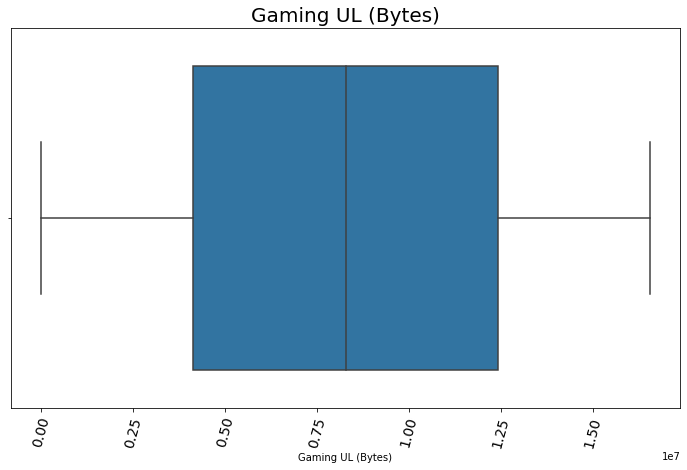

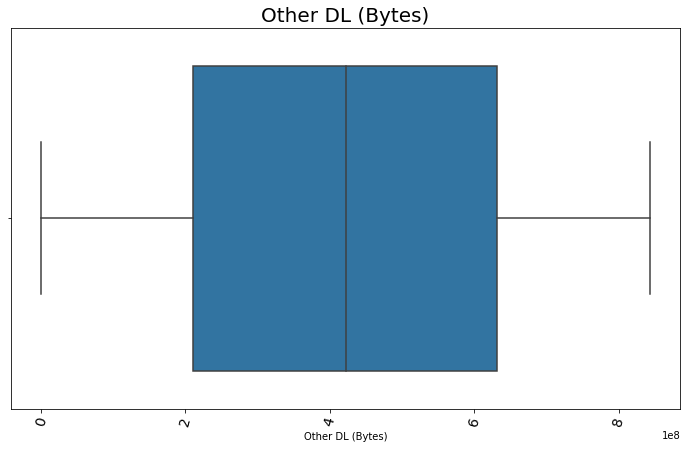

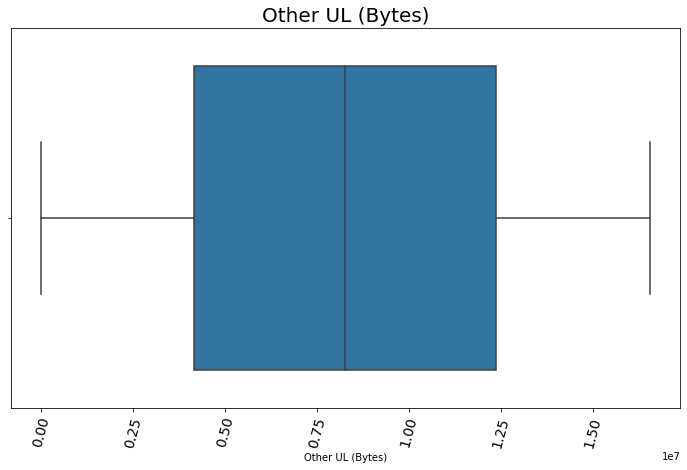

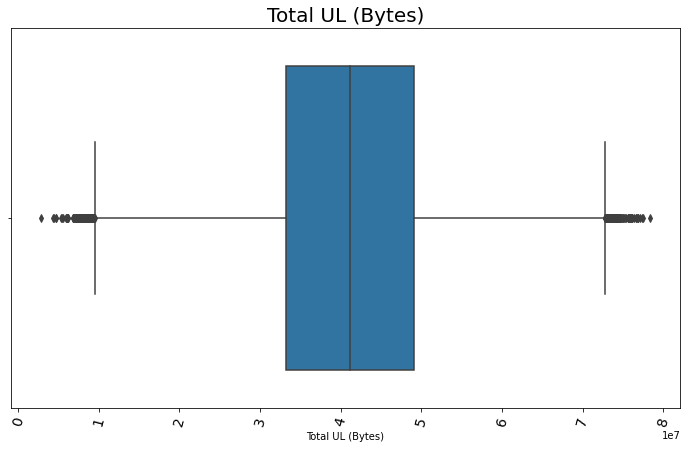

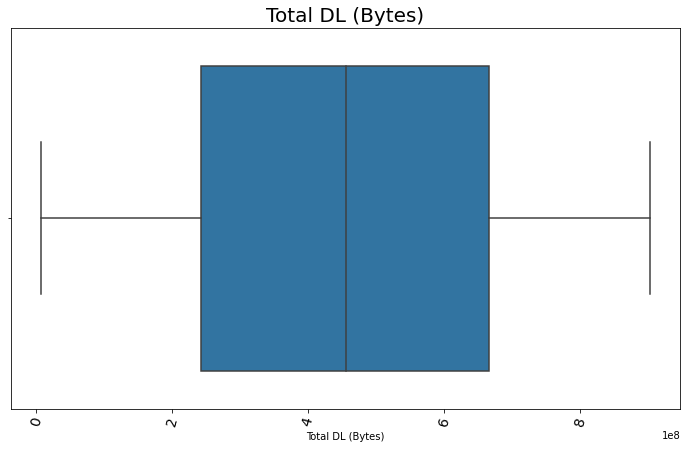

In [20]:
# def fix_outlier(df, column):
#     df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
#     return df[column]
# fixed_df = clean_df.copy()

numerical_columns = clean_df.select_dtypes(include='number').columns.tolist()
for col in numerical_columns:
    # fixed_df[col] = fix_outlier(clean_df, col)
    plot_box(df, col, col)

What we can understand from the above box charts is that there are many outliers for some of the columns such as `Avg RTT DL (ms)`, `250 Kbps < DL TP < 1 Mbps (%)`, and `UL TP > 300 Kbps (%)` but all the social media and app columns don't have outliers. 

#### Histogram plots
This can also be confirmed using histograms. What we will see is that most of the data will be clustered on one side and there will be a few straggler with small frequency on the other side. 

In [21]:
# numerical_columns = clean_df.select_dtypes(include='number').columns.tolist()
# for col in numerical_columns:
#     plot_hist(df, col, 'gold')

### Bivariate Analysis
Here, I am exploreing the relationship between each application & the total DL+UL data using appropriate methods

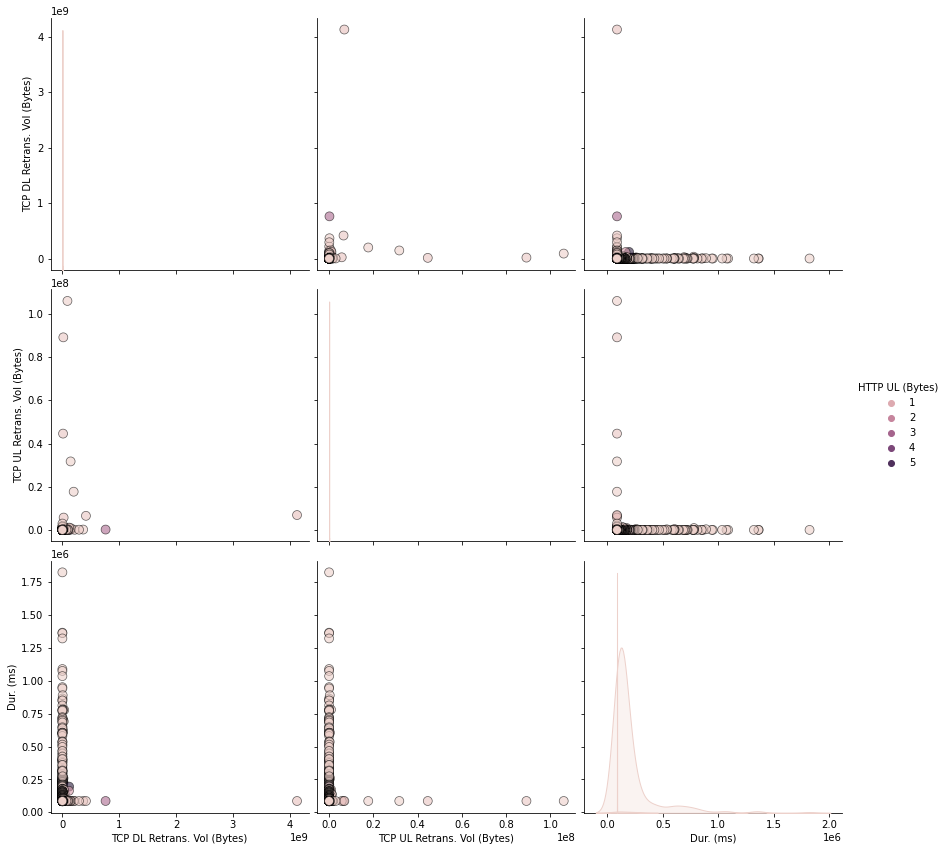

In [22]:
dfPair = clean_df.loc[:1000, ["HTTP UL (Bytes)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Dur. (ms)"]]
sns.pairplot(dfPair, hue = "HTTP UL (Bytes)", diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4)

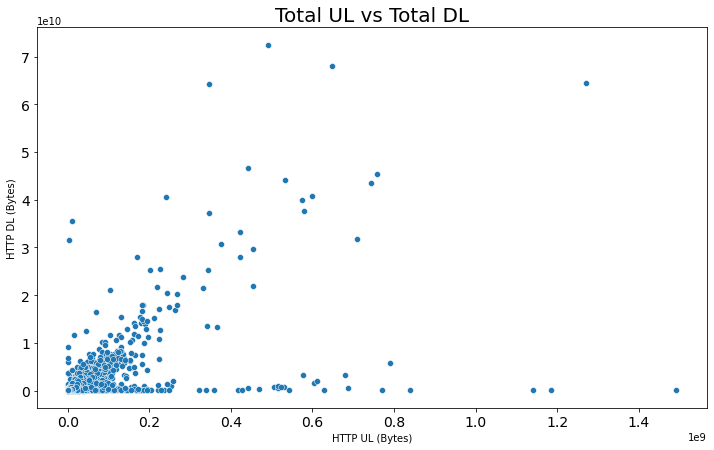

In [23]:
# df.boxplot(figsize=(12, 9))
plot_scatter(clean_df, "HTTP UL (Bytes)", "HTTP DL (Bytes)", "Total UL vs Total DL", None, None)

### Variable transformations
- segment the users into top five decile classes based on the total duration
- compute the total data (DL+UL) per decile class.

In [24]:
app_columns = [col for col in df.columns if col.endswith('L (Bytes)')][2:-2]
app_columns.append('Dur. (ms)')
# display(app_columns)
user_app_ULDL_data_vol = df.groupby(by=['IMSI'])[app_columns].sum()
user_app_ULDL_data_vol.head()
user_app_total_data_vol.head()

user_app_total_data_vol = user_app_ULDL_data_vol.copy()
# group columns into tuples
# app_ULDLs = [
app_ULDL_columns = user_app_total_data_vol.columns.tolist()
app_columns = [[app_ULDL_columns[i], app_ULDL_columns[i+1]] for i in range(0, len(app_ULDL_columns)-1, 2)]
app_columns

for app in app_columns:
    app_name = " ".join(app[0].split()[:-2]).strip()
    user_app_total_data_vol[app_name] = user_app_total_data_vol[app].sum(axis=1)
    user_app_total_data_vol.drop(columns=app, inplace=True)
user_app_total_data_vol.head()

,Dur. (ms),Social Media,Google,Email,Youtube,Netflix,Gaming,Other
IMSI,,,,,,,,
204047108489451.0,869844.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08
204080810288647.0,877385.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08
208200101016140.0,86019.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08
208200101127285.0,86254.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08
208200101148045.0,573923.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09


In [25]:
user_app_total_data_vol['decile_rank'] = pd.qcut(user_app_total_data_vol['Dur. (ms)'], 10, labels=False)

top_5_decile = user_app_total_data_vol[user_app_total_data_vol['decile_rank'] > 4 ]

top_5_decile.head()

,Dur. (ms),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,decile_rank
IMSI,,,,,,,,,
204047108489451.0,869844.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,9
204080810288647.0,877385.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,9
208200101148045.0,573923.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,9
208200101148075.0,372454.0,3787423.0,19749603.0,4327786.0,50907243.0,29882137.0,835218898.0,4.797783e+08,9
208200101148136.0,232058.0,5192710.0,14064424.0,5541425.0,11823461.0,17047546.0,939598732.0,1.069429e+09,8


#### Total data per decile class

In [26]:
top_5_decile_app_volume = top_5_decile.groupby('decile_rank')[['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']].sum()
top_5_decile_app_volume.head()

,Social Media,Google,Email,Youtube,Netflix,Gaming,Other
decile_rank,,,,,,,
5,2.368667e+10,1.011446e+11,2.937519e+10,2.942542e+11,2.942213e+11,5.602022e+12,5.620203e+12
6,2.272677e+10,9.648990e+10,2.788995e+10,2.805453e+11,2.774973e+11,5.369615e+12,5.282693e+12
7,2.919594e+10,1.237756e+11,3.588072e+10,3.590882e+11,3.591808e+11,6.805374e+12,6.795237e+12
8,3.437660e+10,1.467480e+11,4.243359e+10,4.256171e+11,4.265205e+11,8.098630e+12,8.085644e+12
9,5.612191e+10,2.404064e+11,6.977190e+10,6.982836e+11,6.957506e+11,1.318250e+13,1.319225e+13


<AxesSubplot:title={'center':'Total data usage volume vs Decile rank'}, xlabel='decile_rank'>

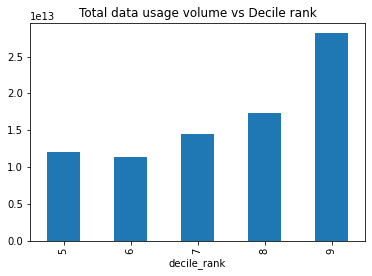

In [27]:
top_5_decile_total_volume = top_5_decile_app_volume.sum(axis=1)
top_5_decile_total_volume.plot.bar(title='Total data usage volume vs Decile rank')

#### Correlation Analysis

Columns to consider:
- Social Media
- Google 
- Email
- Youtube
- Netflix
- Gaming
- Other

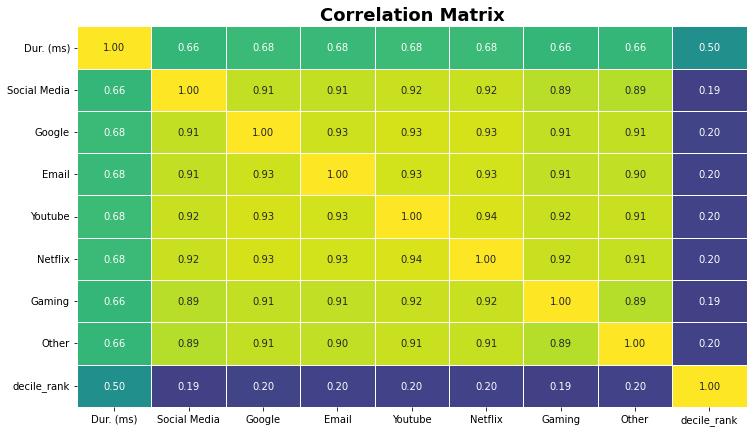

In [28]:
# user_app_total_data_vol.head()
plot_heatmap(user_app_total_data_vol.corr(), "Correlation Matrix")

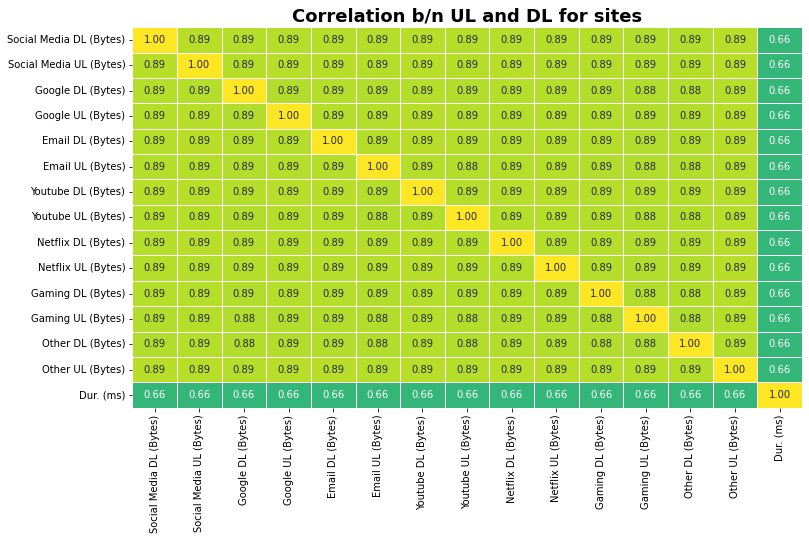

In [29]:
plot_heatmap(user_app_ULDL_data_vol.corr(), "Correlation b/n UL and DL for sites")

In [79]:
# plot_heatmap(clean_df.corr(), "Correlation b/n UL and DL for sites")

### Dimensionality Reduction 

Here, I have used Principal Component Analysis to reduce the dimentions of the data.
I only used the numerical collumns and Generated 2 principal components.


In [31]:
from sklearn.decomposition import PCA

In [106]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(clean_df[numerical_columns])

In [107]:
pc_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
pc_df.head()

,pc1,pc2
0,-5.476976e+07,-2.038665e+08
1,-5.473736e+07,2.721798e+08
2,-5.308603e+07,-2.596544e+08
3,-5.508047e+07,5.424852e+08
4,-5.372207e+07,1.551733e+08


The two principal components I created represent 87 % of the original data which had 40+ columns

In [129]:
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
print(f'Information retained : {round(sum(pca.explained_variance_ratio_), 2)} ')

Explained variation per principal component: [0.68195897 0.1900582 ]
Information retained : 0.87 


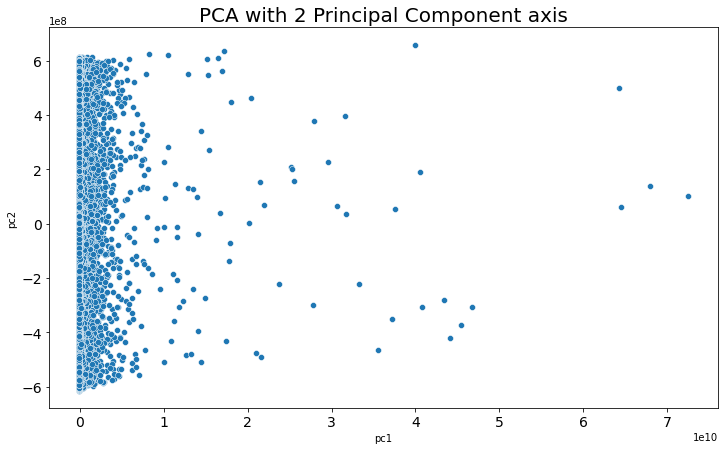

In [109]:
plot_scatter(pc_df, 
            'pc1', 
            'pc2',
            "PCA with 2 Principal Component axis",
            None,
            None)

Using this version of our data would help us train a model faster and it's also easier to visualize.

## Clustering 

In [110]:
from sklearn.cluster import KMeans

In [123]:
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(pc_df)

In [124]:
# plot_scatter(kmeans[:,0], kmeans[:,1], "K-Means_Clustering", None, None)

In [125]:
print(kmeans.shape)

(150001,)


In [126]:
pc_df['cluster'] = kmeans

In [127]:
pc_df.head()

,pc1,pc2,cluster
0,-5.476976e+07,-2.038665e+08,0
1,-5.473736e+07,2.721798e+08,0
2,-5.308603e+07,-2.596544e+08,0
3,-5.508047e+07,5.424852e+08,0
4,-5.372207e+07,1.551733e+08,0


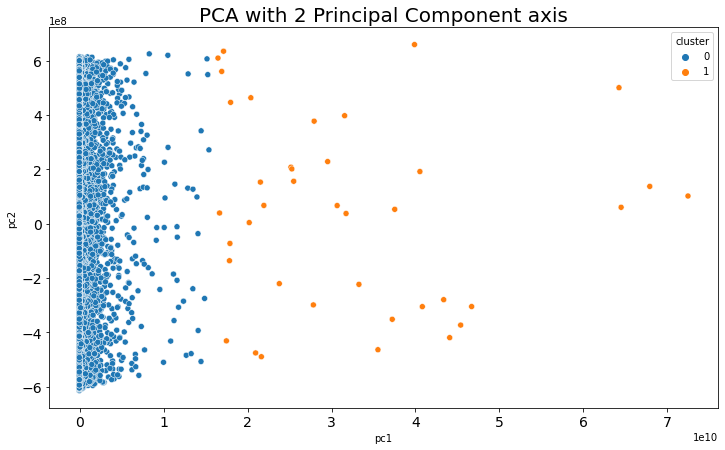

In [128]:
plot_scatter(pc_df, 
            'pc1', 
            'pc2',
            "PCA with 2 Principal Component axis",
            'cluster',
            None)